In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
df = pd.read_excel('multiple_battery_data.xlsx', engine='openpyxl')
df.head()

,SoC,Temperature,Voltage,Label
0,100.000000,298.150000,4.014300,0
1,99.173138,298.849283,3.916820,0
2,98.346276,299.665201,3.887562,0
3,97.519413,300.497825,3.877287,0
4,96.692551,301.327592,3.870545,0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

counts = df['Label'].value_counts().sort_index()
percent = df['Label'].value_counts(normalize=True).sort_index() * 100

dist_df = pd.DataFrame({
    'count': counts,
    'percent(%)': percent.round(2)
})
print(dist_df)


       count  percent(%)
Label                   
0        424       36.81
1        364       31.60
2        364       31.60


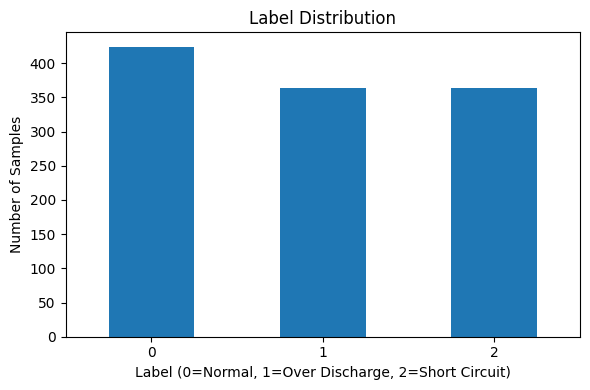

In [5]:
plt.figure(figsize=(6,4))
dist_df['count'].plot(kind='bar')
plt.xlabel('Label (0=Normal, 1=Over Discharge, 2=Short Circuit)')
plt.ylabel('Number of Samples')
plt.title('Label Distribution')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
df.head()

,SoC,Temperature,Voltage,Label
0,100.000000,298.150000,4.014300,0
1,99.173138,298.849283,3.916820,0
2,98.346276,299.665201,3.887562,0
3,97.519413,300.497825,3.877287,0
4,96.692551,301.327592,3.870545,0


In [7]:
X = df[['SoC', 'Temperature', 'Voltage']].values.astype('float32')
y = df['Label'].values.astype('int64')

# 80/10/10 train/val/test 분할 
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [8]:
batch_size = 128
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

In [44]:
class BatteryNet(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, num_classes=3,dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BatteryNet(input_dim=3).to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [39]:
from tqdm import tqdm

In [47]:
num_epochs = 100
patience    = 10  

best_overall = {'val_acc': 0.0}

for lr in [1e-4, 3e-4, 1e-3]:
    for drop_p in [0.2, 0.4, 0.6]:
        # 하이퍼파라미터마다 새로 초기화
        model = BatteryNet(input_dim = 3, dropout=drop_p).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        best_val_acc = 0.0
        best_state   = None
        counter      = 0

        for epoch in tqdm(range(1, num_epochs+1), leave=False, desc=f"LR={lr}, Drop={drop_p}"):
            # --- Training ---
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

            # --- Validation ---
            model.eval()
            correct = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb).argmax(dim=1)
                    correct += (preds == yb).sum().item()
            val_acc = correct / len(val_ds)

            # 최적 모델 저장 & 얼리스톱
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state   = model.state_dict()
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                break

        # 이 하이퍼파라미터 조합의 최고 성능을 전체와 비교
        if best_val_acc > best_overall['val_acc']:
            best_overall.update({
                'val_acc': best_val_acc,
                'lr': lr,
                'dropout': drop_p,
                'state': best_state
            })


print("Best config:", best_overall['lr'], best_overall['dropout'], 
      "Val Acc:", best_overall['val_acc'])
model.load_state_dict(best_overall['state'])

Best config: 0.001 0.2 Val Acc: 0.7652173913043478


<All keys matched successfully>

In [48]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal','Voltage Fault','Short Circuit Fault']))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8017241379310345

Classification Report:
                     precision    recall  f1-score   support

             Normal       0.68      0.88      0.77        43
      Voltage Fault       0.79      0.51      0.62        37
Short Circuit Fault       1.00      1.00      1.00        36

           accuracy                           0.80       116
          macro avg       0.82      0.80      0.80       116
       weighted avg       0.81      0.80      0.79       116


Confusion Matrix:
[[38  5  0]
 [18 19  0]
 [ 0  0 36]]


In [14]:
torch.save(model.state_dict(), 'battery_fault_model.pth')
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

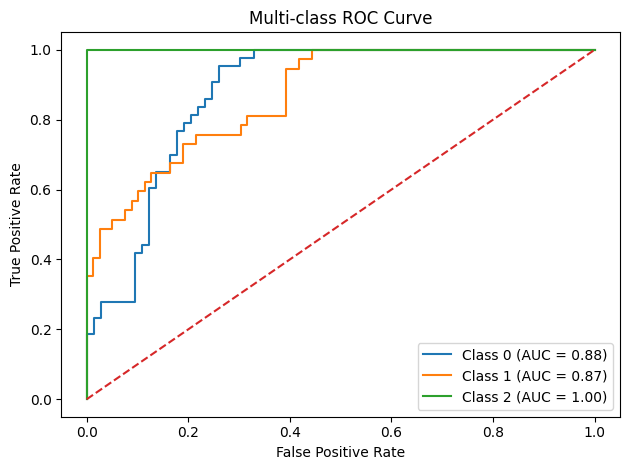

In [49]:
model.eval()
all_scores = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = nn.Softmax(dim=1)(logits).cpu().numpy()
        all_scores.append(probs)
        all_labels.append(yb.numpy())
y_score = np.vstack(all_scores)
y_true = np.concatenate(all_labels)

# 2) 다중 클래스용 이진화
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# 3) 클래스별 ROC 곡선 및 AUC 계산
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4) ROC 곡선 그리기
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch.nn.functional as F

In [18]:
from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, AUROC, F1Score
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        return F.relu(out + identity)

class BatteryClassifier(pl.LightningModule):
    def __init__(self, input_dim=3, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.fc_in = nn.Linear(input_dim, 128)
        self.bn_in = nn.BatchNorm1d(128)
        self.res1 = ResidualBlock(128)
        self.drop = nn.Dropout(0.4)
        self.res2 = ResidualBlock(128)
        self.fc_out = nn.Linear(128, num_classes)
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = F.relu(self.bn_in(self.fc_in(x)))
        x = self.res1(x)
        x = self.drop(x)
        x = self.res2(x)
        return self.fc_out(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy(logits.softmax(1), y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits.softmax(1), y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.log('test_acc', self.accuracy(logits.softmax(1), y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.hparams.lr*10,
            total_steps=self.trainer.estimated_stepping_batches
        )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=64, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=64, num_workers=4)

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')

#Train
model = BatteryClassifier()
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stop, lr_monitor],
    accelerator='auto', devices='auto',    # GPU 자동 감지
    log_every_n_steps=10
)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | fc_in    | Linear             | 512    | train
1 | bn_in    | BatchNorm1d        | 256    | train
2 | res1     | ResidualBlock      | 33.5 K | train
3 | drop     | Dropout            | 0      | train
4 | res2     | ResidualBlock      | 33.5 K | train
5 | fc_out   | Linear             | 387    | train
6 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 15/15 [00:00<00:00, 29.01it/s, v_num=2, train_loss=0.498, train_acc=0.760, val_loss=0.504, val_acc=0.757]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 107.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8103448152542114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8103448152542114}]